# Variation methods


Main contribution of the paper:

- Methodological contribution of empirical robustness for _network_ epistemology. 

Key challenge:

- Test whether inequality (or some other network feature such as density, clustering, or diameter) increases reliability (or some other metric such as speed).
- Counterfactual: had the network been more equal, the group would have been more reliable.
- This requires us to identify networks that differ in their inequality but are otherwise maximally similar.
- We consider three network features: density, clustering, and degree inequality. So networks that have the similar density, clustering and degree inequality are considered maximally similar. (I left out diameter here.)

To achieve this, we develop some variation methods. The main goals for these variation methods are:

1. Control: Ability to tinker with specific network features (density, inequality, clustering)
2. Simplicity
3. Computational tractability
4. Link to (individualistic) intervention 

There are two types of variation methods: 

1. Possibly complex variation methods that can be used to produce networks with specific network properties (density, inequality, clustering), i.e., high control
2. Intuitive and simple variation methods that yield a lower degree of control over the specific network properties (density, inequality, clustering)

The basic ideas in these variation methods are the following:

1. Density
    - Increase by adding edges
    - Keep constant by rewiring edges
    - Decrease by removing edges [not implemented]
2. Clustering
    - Note: the local clustering coefficient of a given node basically is the number of triangles that pass by that node divided by the number of possible triangles that pass by that node. 
    - Increase by adding edges that create new triangles
    - Keep constant ???
    - Decrease by removing edges from existing triangles
3. Inequality
    - Decrease by adding edges randomly (following the uniform degree distribution)
    - Keep constant by adding edges following the original degree distribution (i.e., that of the PUD network)
    - Increase by (a) sequentially adding edges preferentially, or  (b) by adding edges following a degree distribution that is more unequal than the original one [neither implemented]

## Hop over to Outcomes section to see the results of the different variation methods

## Simple variation methods

### Equalizers: tinker with inequality

1. `randomize_network`: Randomly rewire edges (following the uniform degree distribution) [THIS IS WHAT WE CURRENTLY DO]
    - Density $=$
    - Clustering $\downarrow$
    - Inequality $\downarrow$
2. `equalize`: Rewire triangles: Take a triangle, take a node in the triangle, remove the edge in the triangle that does not contain the node, then add a random new edge that creates a new triangle that passed by the node. (The goal was to keep clustering somewhat equal, while increasing equality.)
    - Density $=$
    - Clustering $\approx \downarrow$
    - Inequality $\downarrow$

### Densify
1. [not implemented] Randomly add edges (following the uniform degree distribution)
    - Expectations
        - Density $\uparrow$
        - Clustering $\downarrow$
        - Inequality $\downarrow$
2. `densify`: Add edges following the original degree distribution
    - Density $\uparrow$
    - Clustering $\downarrow$
    - Inequality $=$
3. `cluster`: Add edges that create new triangles (taking into account the original degree distribution)
    - Density $\uparrow$
    - Clustering $\Uparrow$
    - Inequality $\approx$ 

### Clustering
1. `decluster`: Remove edges from existing triangles and add new edge following the original degree distribution
    - Density $=$
    - Clustering $\Downarrow$
    - Inequality $\approx\downarrow$


## Complex variation methods

1. `densify_fancy`: Add edges in such a way to attempt to reach a target clustering coefficient and a target degree distribution (original or uniform). 
    - Basically, the algorithm checks whether the target clustering coefficient has been reached. If not, it adds an edge that increases clustering. If yes, it adds a new edge following the target degree distribution. 
    - **Computationally costly**: after an edge is added, the algorithm calculates the clustering coefficient of the new network, which is computationally costly to an unacceptable degree (I think). 
    - **High degree of control**, especially regarandoming the clustering coefficient: For example, can be used to achieve the following:
        1. Only increase density
            - Density $\uparrow$
            - Clustering $=$
            - Inequality $=$
        2. Increase density and decrease inequality
            - Density $\uparrow$
            - Clustering $=$
            - Inequality $\downarrow$
2. `densify_fancy_speed_up`: This method basically works the same as `densify_fancy`, but has a significant speed up. Instead of calculating the average clustering coefficient whenever an edge is added, we only calculate the new local clusterinf coefficient for nodes that are affected by the newly added edge. 
    - **Computationally not cheap**: although the algorithm is much quicker than `densify_fancy`, it still takes some time. I expect that the computational costs are acceptable.
    - **High control**, especially regarandoming the clustering coefficient.
3. `densify_semi_fancy`: Add edges either to increase clustering or following the target degree distribution — with a fixed probability.
    - Basically, the algorithm throws a (biased) coin to determine whether it will add an edge that increases clustering or add one following the target degree distribution. 
    - Computationally fast. Relies on a biased coin toss instead of calculating the clustering coefficient. The drawback is that the clustering coefficient will change to some degree.
    - Pretty high degree of control.


- Note: we could keep the density fixed by first removing a number of edges and then using `densify_fancy` or `densify_semi_fancy` to add the same number of edges. 

## Thoughts and observations

- I was surprised to learn that both the in-degree and the out-degree distributions of the PUD network are scale free. However, they are not neatly correlated. Nonetheless, my suspicion is that there is a pattern between an agent’s number of publication and both its in-degree and its out-degree. 
- I was surprised to learn that the clustering coefficient is not based on directed graphs (`nx.average_clustering`). 
- In a sense, we have currently only implemented the target degree distribution of the degree distribution of the input network (the PUD network) or the uniform distribution. We could consider other degree distributions (i.e., an unequal distribution that flips the original degree distribution)
- 


## Setup

In [1]:
# import random as random
# import numpy as np
# import seaborn as sns
# import pandas as pd
# import networkx as nx

# import dill 
# import copy

from imports import *
# import random as random

network_pud: nx.DiGraph = dill.load(open('empirical_networks/pud_final.pkl', 'rb'))

In [2]:
def calculate_degree_gini(G, directed = True):
    if directed:
        degrees = [deg for _, deg in G.out_degree()]
    else:
        degrees = [deg for _, deg in G.degree()]
    # Sort the degrees in ascending orandomer
    sorted_x = np.sort(np.array(degrees))
    n = len(np.array(degrees))
    cumx = np.cumsum(sorted_x, dtype=float)
    gini = (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

    return gini

In [3]:
def get_triangles(net: nx.DiGraph):
    """Return the list of all triangles in a directed graph G."""
    triangles = []
    for clique in nx.enumerate_all_cliques(net.to_undirected()):
        if len(clique) <= 3:
            if len(clique) == 3:
                triangles.append(clique)
        else:
            return triangles
    return triangles

## Randomize

In [4]:
def randomize_network(G, p_rewiring):
    # Check if the graph is directed
    is_directed = G.is_directed()

    # Get edges and nodes
    edges = list(G.edges()).copy()
    random.shuffle(edges)
    edges_set = set(edges)
    new_edges_set = edges_set.copy()
    nodes = list(G.nodes()).copy()

    # Find which edges to remove
    to_remove_set = set()
    for old_edge in edges:
        if random.random() < p_rewiring:  # p probability to rewire an edge
            to_remove_set.add(old_edge)
            new_edges_set.remove(old_edge)

    # Generate a new edges
    for edge in to_remove_set:
        new_edge = (random.choice(nodes), random.choice(nodes))
        if not is_directed:
            new_edge = tuple(sorted(new_edge))  # Ensure (u, v) == (v, u) for undirected graphs

        # Avoid duplicate edges and self-loops
        while (new_edge in new_edges_set) or (new_edge[0] == new_edge[1]):
            new_edge = (random.choice(nodes), random.choice(nodes))
            if not is_directed:
                new_edge = tuple(sorted(new_edge))

        new_edges_set.add(new_edge)

    # Create a new graph with updated edges
    G_new = G.copy()
    G_new.remove_edges_from(to_remove_set)
    G_new.add_edges_from(new_edges_set)

    return G_new

In [5]:
random_net_1 = randomize_network(network_pud, p_rewiring=0.1)
random_net_2 = randomize_network(network_pud, p_rewiring=0.2)
random_net_3 = randomize_network(network_pud, p_rewiring=0.3)
random_net_4 = randomize_network(network_pud, p_rewiring=0.4)
random_net_5 = randomize_network(network_pud, p_rewiring=0.5)

In [6]:
data_random = {
    "network": ["original", "random_10%", "random_20%", "random_30%", "random_40%", "random_50%"],
    "degree_gini": [
        calculate_degree_gini(network_pud, directed=True),
        calculate_degree_gini(random_net_1, directed=True),
        calculate_degree_gini(random_net_2, directed=True),
        calculate_degree_gini(random_net_3, directed=True),
        calculate_degree_gini(random_net_4, directed=True),
        calculate_degree_gini(random_net_5, directed=True)
    ],
    "clustering_coefficient": [
        nx.average_clustering(network_pud),
        nx.average_clustering(random_net_1),
        nx.average_clustering(random_net_2),
        nx.average_clustering(random_net_3),
        nx.average_clustering(random_net_4),
        nx.average_clustering(random_net_5)
    ],
    "density": [
        nx.density(network_pud),
        nx.density(random_net_1),
        nx.density(random_net_2),
        nx.density(random_net_3),
        nx.density(random_net_4),
        nx.density(random_net_5)
    ]
}
df_random = pd.DataFrame(data_random)
df_random


,network,degree_gini,clustering_coefficient,density
0,original,0.722814,0.117170,0.000735
1,random_10%,0.671477,0.075506,0.000735
2,random_20%,0.617053,0.049141,0.000735
3,random_30%,0.564373,0.030584,0.000735
4,random_40%,0.506569,0.019223,0.000735
5,random_50%,0.457202,0.012736,0.000735


## Equalize

In [7]:
def equalize(net: nx.DiGraph, n: int) -> nx.DiGraph:
    """
    Equalize the network by rewiring n random edges.
    """
    equalized_net = copy.deepcopy(net)
    triangles = get_triangles(net)
    rewired_triangles = random.sample(triangles, n)
    
    for triangle in rewired_triangles:
        edge = triangle[-2:]  # Take the last two nodes as the edge to be rewired
        # Remove edge
        if equalized_net.has_edge(*edge):
            equalized_net.remove_edge(*edge)
        elif equalized_net.has_edge(edge[1], edge[0]):
            equalized_net.remove_edge(edge[1], edge[0]) 
        else:
            continue
        
        # Add new edge to create a new triangle that passes by the first node
        node = triangle[0] 
        neighbors = list(net.predecessors(node)) + list(net.successors(node))

        sources_sample = random.choices(neighbors, k=10)
        targets_sample = random.choices(neighbors, k=10)
        edge_sample = [
            (source, target) 
            for source in sources_sample 
            for target in targets_sample 
            if source != target and not equalized_net.has_edge(source, target)]
        new_edge = random.choice(edge_sample) # Throws an error if no edges are available
        equalized_net.add_edge(*new_edge)
    return equalized_net

In [8]:
equalized_net_1 = equalize(network_pud, n=1000)
equalized_net_2 = equalize(network_pud, n=2000)
equalized_net_3 = equalize(network_pud, n=3000)
equalized_net_4 = equalize(network_pud, n=4000)
equalized_net_5 = equalize(network_pud, n=5000)


In [9]:
data_equalize = {
    "network": ["original", "equalized_1000", "equalized_2000", "equalized_3000", "equalized_4000", "equalized_5000"],
    "degree_gini": [
        calculate_degree_gini(network_pud, directed=True),
        calculate_degree_gini(equalized_net_1, directed=True),
        calculate_degree_gini(equalized_net_2, directed=True),
        calculate_degree_gini(equalized_net_3, directed=True),
        calculate_degree_gini(equalized_net_4, directed=True),
        calculate_degree_gini(equalized_net_5, directed=True)
    ],
    "clustering_coefficient": [
        nx.average_clustering(network_pud),
        nx.average_clustering(equalized_net_1),
        nx.average_clustering(equalized_net_2),
        nx.average_clustering(equalized_net_3),
        nx.average_clustering(equalized_net_4),
        nx.average_clustering(equalized_net_5)
    ],
    "density": [
        nx.density(network_pud),
        nx.density(equalized_net_1),
        nx.density(equalized_net_2),
        nx.density(equalized_net_3),
        nx.density(equalized_net_4),
        nx.density(equalized_net_5)
    ]
}

df_equalize = pd.DataFrame(data_equalize)
df_equalize

,network,degree_gini,clustering_coefficient,density
0,original,0.722814,0.117170,0.000735
1,equalized_1000,0.713133,0.108845,0.000735
2,equalized_2000,0.703244,0.102253,0.000735
3,equalized_3000,0.696223,0.097231,0.000735
4,equalized_4000,0.689399,0.093112,0.000735
5,equalized_5000,0.684654,0.089297,0.000735


## Densify

In [10]:
def densify_network(net: nx.DiGraph, n_edges: int) -> nx.DiGraph:
    # Create a copy of the original network
    densified_net = copy.deepcopy(net)
    
    # Get the degree distribution
    in_degrees = dict(net.in_degree())
    out_degrees = dict(net.out_degree())
    multiplier = 10
    targets = random.choices(
        list(in_degrees.keys()), 
        weights=list(in_degrees.values()), 
        k=multiplier*n_edges
    )
    sources = random.choices(
        list(out_degrees.keys()), 
        weights=out_degrees.values(), 
        k=multiplier*n_edges
    )

    edges_new = list(set(zip(sources, targets))) 
    edges_new = [edge for edge in edges_new if edge[0] != edge[1]]  
    edges_new = [edge for edge in edges_new if not edge in net.edges()]
    edges_new = edges_new[:n_edges] 
    
    densified_net.add_edges_from(edges_new)
    return densified_net

In [11]:
densify_net_1 = densify_network(network_pud, n_edges=1000)
print("Done")
densify_net_2 = densify_network(network_pud, n_edges=2000)
print("Done")
densify_net_3 = densify_network(network_pud, n_edges=3000)
print("Done")
densify_net_4 = densify_network(network_pud, n_edges=4000)
print("Done")
densify_net_5 = densify_network(network_pud, n_edges=5000)
print("Done")

Done
Done
Done
Done
Done


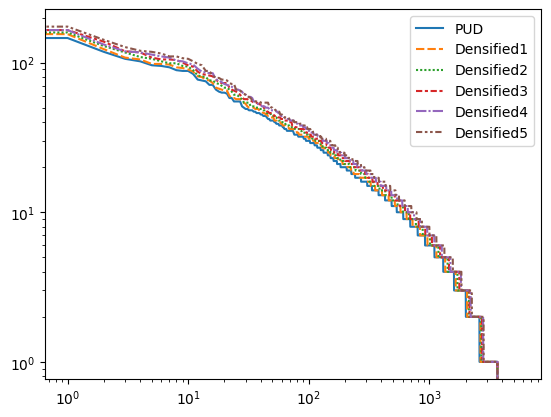

In [12]:
out_degrees_pud = sorted(list(dict(network_pud.out_degree()).values()), reverse=True)

out_degrees_densify_1 = sorted(list(dict(densify_net_1.out_degree()).values()), reverse=True)
out_degrees_densify_2 = sorted(list(dict(densify_net_2.out_degree()).values()), reverse=True)
out_degrees_densify_3 = sorted(list(dict(densify_net_3.out_degree()).values()), reverse=True)
out_degrees_densify_4 = sorted(list(dict(densify_net_4.out_degree()).values()), reverse=True)
out_degrees_densify_5 = sorted(list(dict(densify_net_5.out_degree()).values()), reverse=True)

data = zip(
    out_degrees_pud, 
    out_degrees_densify_1, out_degrees_densify_2, out_degrees_densify_3, out_degrees_densify_4, out_degrees_densify_5)

df = pd.DataFrame(data, columns=["PUD", "Densified1", "Densified2", "Densified3", "Densified4", "Densified5"])

fig = sns.lineplot(df)
fig.set_yscale("log")
fig.set_xscale("log")


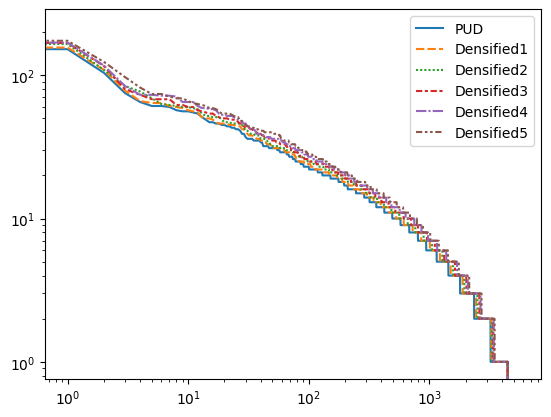

In [13]:
in_degrees_pud = sorted(list(dict(network_pud.in_degree()).values()), reverse=True)

in_degrees_densify_1 = sorted(list(dict(densify_net_1.in_degree()).values()), reverse=True)
in_degrees_densify_2 = sorted(list(dict(densify_net_2.in_degree()).values()), reverse=True)
in_degrees_densify_3 = sorted(list(dict(densify_net_3.in_degree()).values()), reverse=True)
in_degrees_densify_4 = sorted(list(dict(densify_net_4.in_degree()).values()), reverse=True)
in_degrees_densify_5 = sorted(list(dict(densify_net_5.in_degree()).values()), reverse=True)

data = zip(
    in_degrees_pud, 
    in_degrees_densify_1, in_degrees_densify_2, in_degrees_densify_3, in_degrees_densify_4, in_degrees_densify_5)

df = pd.DataFrame(data, columns=["PUD", "Densified1", "Densified2", "Densified3", "Densified4", "Densified5"])

fig = sns.lineplot(df)
fig.set_yscale("log")
fig.set_xscale("log")


In [14]:
data_densify = {
    "network": ["original", "densified_1000", "densified_2000", "densified_3000", "densified_4000", "densified_5000"],
    "degree_gini": [
        calculate_degree_gini(network_pud, directed=True),
        calculate_degree_gini(densify_net_1, directed=True),
        calculate_degree_gini(densify_net_2, directed=True),
        calculate_degree_gini(densify_net_3, directed=True),
        calculate_degree_gini(densify_net_4, directed=True),
        calculate_degree_gini(densify_net_5, directed=True)
    ],
    "clustering_coefficient": [
        nx.average_clustering(network_pud),
        nx.average_clustering(densify_net_1),
        nx.average_clustering(densify_net_2),
        nx.average_clustering(densify_net_3),
        nx.average_clustering(densify_net_4),
        nx.average_clustering(densify_net_5)
    ],
    "density": [
        nx.density(network_pud),
        nx.density(densify_net_1),
        nx.density(densify_net_2),
        nx.density(densify_net_3),
        nx.density(densify_net_4),
        nx.density(densify_net_5)
    ]
}

df_densify = pd.DataFrame(data_densify)
df_densify

,network,degree_gini,clustering_coefficient,density
0,original,0.722814,0.117170,0.000735
1,densified_1000,0.724207,0.109314,0.000768
2,densified_2000,0.724142,0.103218,0.000801
3,densified_3000,0.725951,0.095413,0.000834
4,densified_4000,0.725862,0.090589,0.000867
5,densified_5000,0.726286,0.085496,0.000900


In [15]:
def densify_semi_fancy(
    net: nx.DiGraph, n_edges: int, p_increase_clustering: float, target_degree_dist: str = "original",
) -> nx.DiGraph:
    """
    Densifies a directed network by adding new edges, balancing between increasing 
    ing
    and preserving a target degree distribution.

    Parameters
    ----------
    net : nx.DiGraph
        The original directed network to densify.
    n_edges : int
        The number of new edges to add.
    p_increase_clustering : float
        Probability (between 0 and 1) that a new edge is added to increase clustering
        (i.e., create new triangles). Otherwise, new edges are added based on the 
        target degree distribution.
    target_degree_dist : str, optional
        The target degree distribution for new edges.
        "original" uses the original network's degree distribution,
        "uniform" assigns equal probability to all nodes. Default is "original".

    Returns
    -------
    nx.DiGraph
        A new directed network with additional edges.
    """
    
    # Create a copy of the original network
    net_new = copy.deepcopy(net)
    
    if target_degree_dist == "original":
        # Use the original degree distribution
        out_degrees = dict(net.out_degree())
        in_degrees = dict(net.in_degree())
    if target_degree_dist == "uniform":
        out_degrees = {node: 1 for node in net.nodes()}
        in_degrees = {node: 1 for node in net.nodes()}

    # Add edges in neighborhoods
    n_edges_added = 0
    edges_added_clustering = 0
    edges_added_degree_dist = 0
    while n_edges_added < n_edges:
        if random.random() < p_increase_clustering:
            # Add new edge to increase clustering
            possible_edges = []
            while possible_edges == []:
                node = random.choice(list(net.nodes()))
                neighbors = list(net.predecessors(node)) + list(net.successors(node))
                out_degrees_neighbors = {node: out_degrees[node] for node in neighbors}
                in_degrees_neighbors = {node: in_degrees[node] for node in neighbors}
                out_weights = out_degrees_neighbors.values()
                if all(out_weights) == 0:
                    out_weights = np.ones(len(out_degrees_neighbors.keys()))
                
                in_weights = in_degrees_neighbors.values()
                if all(in_weights) == 0:
                    in_weights = np.ones(len(in_degrees_neighbors.keys()))
                
                sources = random.choices(list(out_degrees_neighbors.keys()), weights=out_weights, k=10)
                targets = random.choices(list(in_degrees_neighbors.keys()), weights=in_weights, k=10)
                possible_edges = [
                    (source, target) for source in sources for target in targets
                    if source != target and not net_new.in_edges(source, target)
                ]
                if possible_edges != []:
                    new_edge = random.choice(possible_edges)
                    n_edges_added += 1
                    net_new.add_edge(*new_edge)
                    edges_added_clustering += 1
        else:
            # Add new edge based on target degree distribution
            edge_sample = []
            while edge_sample == []:
                sources_sample = random.choices(list(out_degrees.keys()), weights=out_degrees.values(), k=10)
                targets_sample = random.choices(list(in_degrees.keys()), weights=in_degrees.values(), k=10)
                edge_sample = [
                    (source, target) 
                    for source in sources_sample 
                    for target in targets_sample 
                    if source != target and not net_new.has_edge(source, target)]
                if edge_sample != []:
                    new_edge = random.choice(edge_sample) # Throws an error if no edges are available
                    n_edges_added += 1
                    net_new.add_edge(*new_edge)
                    edges_added_degree_dist += 1
        # print(f"{n_edges_added=:,} edges added")
    print(f"{edges_added_clustering:,} edges added to increase clustering")
    print(f"{edges_added_degree_dist:,} edges added based on {target_degree_dist} degree distribution")
    return net_new

In [16]:
p_increase_clustering = 0.33

densify_semi_1 = densify_semi_fancy(
    network_pud, n_edges=1000, p_increase_clustering=p_increase_clustering, target_degree_dist="uniform",
)
densify_semi_2 = densify_semi_fancy(
    network_pud, n_edges=2000, p_increase_clustering=p_increase_clustering, target_degree_dist="uniform",
)
densify_semi_3 = densify_semi_fancy(
    network_pud, n_edges=3000, p_increase_clustering=p_increase_clustering, target_degree_dist="uniform",
)
densify_semi_4 = densify_semi_fancy(
    network_pud, n_edges=4000, p_increase_clustering=p_increase_clustering, target_degree_dist="uniform",
)
densify_semi_5 = densify_semi_fancy(
    network_pud, n_edges=5000, p_increase_clustering=p_increase_clustering, target_degree_dist="uniform",
)

318 edges added to increase clustering
682 edges added based on uniform degree distribution
634 edges added to increase clustering
1,366 edges added based on uniform degree distribution
1,019 edges added to increase clustering
1,981 edges added based on uniform degree distribution
1,333 edges added to increase clustering
2,667 edges added based on uniform degree distribution
1,609 edges added to increase clustering
3,391 edges added based on uniform degree distribution


In [17]:
data_densify_semi = {
    "network": [
        "original", 
        "densified_semi_fancy_1000", 
        "densified_semi_fancy_2000", 
        "densified_semi_fancy_3000", 
        "densified_semi_fancy_4000", 
        "densified_semi_fancy_5000"
    ],
    "degree_gini": [
        calculate_degree_gini(network_pud, directed=True),
        calculate_degree_gini(densify_semi_1, directed=True),
        calculate_degree_gini(densify_semi_2, directed=True),
        calculate_degree_gini(densify_semi_3, directed=True),
        calculate_degree_gini(densify_semi_4, directed=True),
        calculate_degree_gini(densify_semi_5, directed=True)
    ],
    "clustering_coefficient": [
        nx.average_clustering(network_pud),
        nx.average_clustering(densify_semi_1),
        nx.average_clustering(densify_semi_2),
        nx.average_clustering(densify_semi_3),
        nx.average_clustering(densify_semi_4),
        nx.average_clustering(densify_semi_5)
    ],
    "density": [
        nx.density(network_pud),
        nx.density(densify_semi_1),
        nx.density(densify_semi_2),
        nx.density(densify_semi_3),
        nx.density(densify_semi_4),
        nx.density(densify_semi_5)
    ]
}

df_densify_semi = pd.DataFrame(data_densify_semi)
df_densify_semi

,network,degree_gini,clustering_coefficient,density
0,original,0.722814,0.117170,0.000735
1,densified_semi_fancy_1000,0.704629,0.121394,0.000766
2,densified_semi_fancy_2000,0.687211,0.117563,0.000797
3,densified_semi_fancy_3000,0.670147,0.116051,0.000826
4,densified_semi_fancy_4000,0.656086,0.111236,0.000856
5,densified_semi_fancy_5000,0.638402,0.102461,0.000884


In [18]:
def densify_fancy(
    net: nx.DiGraph, n_edges: int, target_degree_dist: str = "original", target_clustering: float = None,
) -> nx.DiGraph:
    """
    Densifies a directed network by adding new edges to increase its density, 
    while optionally targeting a specific degree distribution and clustering coefficient.
    Priority is given to targeting the specified clustering coefficient.

    Parameters
    ----------
    net : nx.DiGraph
        The original directed network to densify.
    n_edges : int
        The number of edges to add.
    target_degree_dist : str, optional
        The target degree distribution for new edges. 
        "original" preserves the original degree distribution, 
        "uniform" assigns equal probability to all nodes. Default is "original".
    target_clustering : float, optional
        The desired average clustering coefficient. If None, uses the original network's clustering.

    Returns
    -------
    nx.DiGraph
        A new directed network with increased density and optionally modified clustering/degree distribution.
    """
    
    # Create a copy of the original network
    net_new = copy.deepcopy(net)
    
    if target_clustering is None:
        target_clustering = nx.average_clustering(net)
    if target_degree_dist == "original":
        # Use the original degree distribution
        out_degrees = dict(net.out_degree())
        in_degrees = dict(net.in_degree())
    if target_degree_dist == "uniform":
        out_degrees = {node: 1 for node in net.nodes()}
        in_degrees = {node: 1 for node in net.nodes()}

    # Add edges in neighborhoods
    n_edges_added = 0
    edges_added_clustering = 0
    edges_added_degree_dist = 0
    new_clustering = nx.average_clustering(net_new)
    while n_edges_added < n_edges:
        if new_clustering < target_clustering:
            # Add new edge to increase clustering
            node = random.choice(list(net.nodes()))
            neighbors = list(net.predecessors(node)) + list(net.successors(node))
            out_degrees_neighbors = {node: out_degrees[node] for node in neighbors}
            in_degrees_neighbors = {node: in_degrees[node] for node in neighbors}
            out_weights = out_degrees_neighbors.values()
            if all(out_weights) == 0:
                out_weights = np.ones(len(out_degrees_neighbors.keys()))
            in_weights = in_degrees_neighbors.values()
        
            if all(in_weights) == 0:
                in_weights = np.ones(len(in_degrees_neighbors.keys()))
            
            sources = random.choices(list(out_degrees_neighbors.keys()), weights=out_weights, k=10)
            targets = random.choices(list(in_degrees_neighbors.keys()), weights=in_weights, k=10)
            possible_edges = [
                (source, target) for source in sources for target in targets
                if source != target and not net_new.in_edges(source, target)
            ]
            if possible_edges != []:
                new_edge = random.choice(possible_edges)
                n_edges_added += 1
                net_new.add_edge(*new_edge)
                new_clustering = nx.average_clustering(net_new)
                edges_added_clustering += 1
        else:
            # Add new edge based on target degree distribution
            sources_sample = random.choices(list(out_degrees.keys()), weights=out_degrees.values(), k=10)
            targets_sample = random.choices(list(in_degrees.keys()), weights=in_degrees.values(), k=10)
            edge_sample = [
                (source, target) 
                for source in sources_sample 
                for target in targets_sample 
                if source != target and not net_new.has_edge(source, target)]
            if edge_sample != []:
                new_edge = random.choice(edge_sample) # Throws an error if no edges are available
                n_edges_added += 1
                net_new.add_edge(*new_edge)
                new_clustering = nx.average_clustering(net_new)
                edges_added_degree_dist += 1
        print(f"{n_edges_added=:,} edges added")
    print(f"{edges_added_clustering:,} edges added to increase clustering")
    print(f"{edges_added_degree_dist:,} edges added based on {target_degree_dist} degree distribution")
    return net_new

In [19]:
densify_fancy_01 = densify_fancy(network_pud, n_edges=100, target_degree_dist="uniform") # Approx 25 seconds

n_edges_added=1 edges added
n_edges_added=2 edges added
n_edges_added=3 edges added
n_edges_added=3 edges added
n_edges_added=4 edges added
n_edges_added=5 edges added
n_edges_added=6 edges added
n_edges_added=7 edges added
n_edges_added=8 edges added
n_edges_added=8 edges added
n_edges_added=8 edges added
n_edges_added=9 edges added
n_edges_added=10 edges added
n_edges_added=11 edges added
n_edges_added=12 edges added
n_edges_added=13 edges added
n_edges_added=14 edges added
n_edges_added=15 edges added
n_edges_added=16 edges added
n_edges_added=17 edges added
n_edges_added=18 edges added
n_edges_added=19 edges added
n_edges_added=20 edges added
n_edges_added=21 edges added
n_edges_added=22 edges added
n_edges_added=23 edges added
n_edges_added=24 edges added
n_edges_added=25 edges added
n_edges_added=26 edges added
n_edges_added=27 edges added
n_edges_added=28 edges added
n_edges_added=29 edges added
n_edges_added=29 edges added
n_edges_added=29 edges added
n_edges_added=29 edges add

In [20]:
densify_fancy_05 = densify_fancy(network_pud, n_edges=500, target_degree_dist="uniform") # Approx 2 minutes

n_edges_added=1 edges added
n_edges_added=1 edges added
n_edges_added=1 edges added
n_edges_added=1 edges added
n_edges_added=1 edges added
n_edges_added=1 edges added
n_edges_added=2 edges added
n_edges_added=3 edges added
n_edges_added=4 edges added
n_edges_added=5 edges added
n_edges_added=5 edges added
n_edges_added=5 edges added
n_edges_added=5 edges added
n_edges_added=5 edges added
n_edges_added=5 edges added
n_edges_added=5 edges added
n_edges_added=5 edges added
n_edges_added=5 edges added
n_edges_added=6 edges added
n_edges_added=7 edges added
n_edges_added=8 edges added
n_edges_added=9 edges added
n_edges_added=10 edges added
n_edges_added=11 edges added
n_edges_added=12 edges added
n_edges_added=13 edges added
n_edges_added=14 edges added
n_edges_added=15 edges added
n_edges_added=16 edges added
n_edges_added=17 edges added
n_edges_added=18 edges added
n_edges_added=19 edges added
n_edges_added=20 edges added
n_edges_added=21 edges added
n_edges_added=22 edges added
n_edges

In [21]:
densify_fancy_1 = densify_fancy(network_pud, n_edges=1000, target_degree_dist="uniform") # Approx 4:15 minutes

n_edges_added=1 edges added
n_edges_added=2 edges added
n_edges_added=2 edges added
n_edges_added=2 edges added
n_edges_added=3 edges added
n_edges_added=4 edges added
n_edges_added=4 edges added
n_edges_added=4 edges added
n_edges_added=4 edges added
n_edges_added=4 edges added
n_edges_added=4 edges added
n_edges_added=4 edges added
n_edges_added=4 edges added
n_edges_added=4 edges added
n_edges_added=4 edges added
n_edges_added=4 edges added
n_edges_added=4 edges added
n_edges_added=4 edges added
n_edges_added=5 edges added
n_edges_added=6 edges added
n_edges_added=7 edges added
n_edges_added=8 edges added
n_edges_added=9 edges added
n_edges_added=9 edges added
n_edges_added=10 edges added
n_edges_added=10 edges added
n_edges_added=10 edges added
n_edges_added=10 edges added
n_edges_added=10 edges added
n_edges_added=10 edges added
n_edges_added=10 edges added
n_edges_added=10 edges added
n_edges_added=10 edges added
n_edges_added=10 edges added
n_edges_added=10 edges added
n_edges_a

In [22]:
data_densify_fancy = {
    "network": ["original", "densify_fancy_0100", "densify_fancy_0500", "densify_fancy_1000"], #, "cluster_constant_2", "cluster_constant_3", "cluster_constant_4", "cluster_constant_5"],
    "degree_gini": [
        calculate_degree_gini(network_pud, directed=True),
        calculate_degree_gini(densify_fancy_01, directed=True),
        calculate_degree_gini(densify_fancy_05, directed=True),
        calculate_degree_gini(densify_fancy_1, directed=True)
    ],
    "clustering_coefficient": [
        nx.average_clustering(network_pud),
        nx.average_clustering(densify_fancy_01),
        nx.average_clustering(densify_fancy_05),
        nx.average_clustering(densify_fancy_1)
    ],
    "density": [
        nx.density(network_pud),
        nx.density(densify_fancy_01),
        nx.density(densify_fancy_05),
        nx.density(densify_fancy_1)
    ]
}

df_densify_fancy = pd.DataFrame(data_densify_fancy)
df_densify_fancy

,network,degree_gini,clustering_coefficient,density
0,original,0.722814,0.117170,0.000735
1,densify_fancy_0100,0.720719,0.117227,0.000738
2,densify_fancy_0500,0.712599,0.117168,0.000750
3,densify_fancy_1000,0.703904,0.117242,0.000766


In [23]:
def densify_fancy_speed_up(
    net: nx.DiGraph, n_edges: int, target_degree_dist: str = "original", target_average_clustering: float = None,
) -> nx.DiGraph:
    """
    Densifies a directed network by adding new edges to increase its density, 
    while optionally targeting a specific degree distribution and clustering coefficient.
    Priority is given to targeting the specified clustering coefficient.

    Parameters
    ----------
    net : nx.DiGraph
        The original directed network to densify.
    n_edges : int
        The number of edges to add.
    target_degree_dist : str, optional
        The target degree distribution for new edges. 
        "original" preserves the original degree distribution, 
        "uniform" assigns equal probability to all nodes. Default is "original".
    target_clustering : float, optional
        The desired average clustering coefficient. If None, uses the original network's clustering.

    Returns
    -------
    nx.DiGraph
        A new directed network with increased density and optionally modified clustering/degree distribution.
    """
    
    # Create a copy of the original network
    net_new = copy.deepcopy(net)
    
    if target_average_clustering is None:
        target_average_clustering = nx.average_clustering(net)
    if target_degree_dist == "original":
        # Use the original degree distribution
        out_degrees = dict(net.out_degree())
        in_degrees = dict(net.in_degree())
    if target_degree_dist == "uniform":
        out_degrees = {node: 1 for node in net.nodes()}
        in_degrees = {node: 1 for node in net.nodes()}
    clustering_dict: dict = nx.clustering(net_new)
    
    # Add edges in neighborhoods
    n_edges_added = 0
    edges_added_clustering = 0
    edges_added_degree_dist = 0
    new_average_clustering = np.average(list(clustering_dict.values()))
    while n_edges_added < n_edges:
        if new_average_clustering < target_average_clustering:
            # Add new edge to increase clustering
            node = random.choice(list(net.nodes()))
            neighbors = list(net.predecessors(node)) + list(net.successors(node))
            out_degrees_neighbors = {node: out_degrees[node] for node in neighbors}
            in_degrees_neighbors = {node: in_degrees[node] for node in neighbors}
            out_weights = out_degrees_neighbors.values()
            if all(out_weights) == 0:
                out_weights = np.ones(len(out_degrees_neighbors.keys()))
            in_weights = in_degrees_neighbors.values()
        
            if all(in_weights) == 0:
                in_weights = np.ones(len(in_degrees_neighbors.keys()))
            
            sources = random.choices(list(out_degrees_neighbors.keys()), weights=out_weights, k=10)
            targets = random.choices(list(in_degrees_neighbors.keys()), weights=in_weights, k=10)
            possible_edges = [
                (source, target) for source in sources for target in targets
                if source != target and not net_new.in_edges(source, target)
            ]
            if possible_edges != []:
                new_edge = random.choice(possible_edges)
                n_edges_added += 1
                net_new.add_edge(*new_edge)
                neighborhood_0 = list(net_new.predecessors(new_edge[0])) + list(net_new.successors(new_edge[0]))
                neighborhood_1 = list(net_new.predecessors(new_edge[1])) + list(net_new.successors(new_edge[1]))
                affected_nodes = [new_edge[0], new_edge[1]] + list(set(neighborhood_0).intersection(set(neighborhood_1)))
                for node in affected_nodes:
                    clustering_dict[node] = nx.clustering(net_new, node)
                new_average_clustering = np.average(list(clustering_dict.values()))
                edges_added_clustering += 1
        else:
            # Add new edge based on target degree distribution
            sources_sample = random.choices(list(out_degrees.keys()), weights=out_degrees.values(), k=10)
            targets_sample = random.choices(list(in_degrees.keys()), weights=in_degrees.values(), k=10)
            edge_sample = [
                (source, target) 
                for source in sources_sample 
                for target in targets_sample 
                if source != target and not net_new.has_edge(source, target)]
            if edge_sample != []:
                new_edge = random.choice(edge_sample) # Throws an error if no edges are available
                n_edges_added += 1
                net_new.add_edge(*new_edge)
                neighborhood_0 = list(net_new.predecessors(new_edge[0])) + list(net_new.successors(new_edge[0]))
                neighborhood_1 = list(net_new.predecessors(new_edge[1])) + list(net_new.successors(new_edge[1]))
                affected_nodes = [new_edge[0], new_edge[1]] + list(set(neighborhood_0).intersection(set(neighborhood_1)))
                for node in affected_nodes:
                    clustering_dict[node] = nx.clustering(net_new, node)
                new_average_clustering = np.average(list(clustering_dict.values()))
                edges_added_degree_dist += 1
        # print(f"{n_edges_added=:,} edges added")
    print(f"{edges_added_clustering:,} edges added to increase clustering")
    print(f"{edges_added_degree_dist:,} edges added based on {target_degree_dist} degree distribution")
    return net_new

In [24]:
densify_fancy_speedy_1000 = densify_fancy_speed_up(network_pud, n_edges=1000, target_degree_dist="uniform")
densify_fancy_speedy_2000 = densify_fancy_speed_up(network_pud, n_edges=2000, target_degree_dist="uniform")
densify_fancy_speedy_3000 = densify_fancy_speed_up(network_pud, n_edges=3000, target_degree_dist="uniform")
densify_fancy_speedy_4000 = densify_fancy_speed_up(network_pud, n_edges=4000, target_degree_dist="uniform")
densify_fancy_speedy_5000 = densify_fancy_speed_up(network_pud, n_edges=5000, target_degree_dist="uniform")

303 edges added to increase clustering
697 edges added based on uniform degree distribution
585 edges added to increase clustering
1,415 edges added based on uniform degree distribution
1,010 edges added to increase clustering
1,990 edges added based on uniform degree distribution
1,630 edges added to increase clustering
2,370 edges added based on uniform degree distribution
2,219 edges added to increase clustering
2,781 edges added based on uniform degree distribution


In [25]:
data_densify_fancy = {
    "network": ["original", "densify_fancy_speedy_1000", "densify_fancy_speedy_2000", "densify_fancy_speedy_3000", "densify_fancy_speedy_4000", "densify_fancy_speedy_5000"], 
    "degree_gini": [
        calculate_degree_gini(network_pud, directed=True),
        calculate_degree_gini(densify_fancy_speedy_1000, directed=True),
        calculate_degree_gini(densify_fancy_speedy_2000, directed=True),
        calculate_degree_gini(densify_fancy_speedy_3000, directed=True),
        calculate_degree_gini(densify_fancy_speedy_4000, directed=True),
        calculate_degree_gini(densify_fancy_speedy_5000, directed=True)
    ],
    "clustering_coefficient": [
        nx.average_clustering(network_pud),
        nx.average_clustering(densify_fancy_speedy_1000),
        nx.average_clustering(densify_fancy_speedy_2000),
        nx.average_clustering(densify_fancy_speedy_3000),
        nx.average_clustering(densify_fancy_speedy_4000),
        nx.average_clustering(densify_fancy_speedy_5000)
    ],
    "density": [
        nx.density(network_pud),
        nx.density(densify_fancy_speedy_1000),
        nx.density(densify_fancy_speedy_2000),
        nx.density(densify_fancy_speedy_3000),
        nx.density(densify_fancy_speedy_4000),
        nx.density(densify_fancy_speedy_5000)
    ]
}

df_densify_fancy_speedy = pd.DataFrame(data_densify_fancy)
df_densify_fancy_speedy

,network,degree_gini,clustering_coefficient,density
0,original,0.722814,0.117170,0.000735
1,densify_fancy_speedy_1000,0.702864,0.117194,0.000766
2,densify_fancy_speedy_2000,0.683735,0.117134,0.000797
3,densify_fancy_speedy_3000,0.670467,0.117224,0.000827
4,densify_fancy_speedy_4000,0.660239,0.117144,0.000853
5,densify_fancy_speedy_5000,0.648853,0.117124,0.000876


## Cluster

In [26]:
def get_triangles(G: nx.DiGraph):
    """Return the list of all triangles in a directed graph G."""
    triangles = []
    for clique in nx.enumerate_all_cliques(G.to_undirected()):
        if len(clique) <= 3:
            if len(clique) == 3:
                triangles.append(clique)
        else:
            return triangles
    return triangles

triangles_pud = get_triangles(network_pud)
len(triangles_pud)

def decluster(net: nx.DiGraph, n_triangles: int) -> nx.DiGraph:
    """
    Decluster the network by rewiring n_triangles random triangles.
    """
    decluster_net = copy.deepcopy(net)
    triangles = get_triangles(net)
    rewired_triangles = random.sample(triangles, n_triangles)
    rewired_edges = [
        (source, target) 
        for (source, target, _) in rewired_triangles
    ] # Warning: triangles are based on undirected graph!
    
    for edge in rewired_edges:
        # Remove edge
        if decluster_net.has_edge(*edge):
            decluster_net.remove_edge(*edge)
        elif decluster_net.has_edge(edge[1], edge[0]):
            decluster_net.remove_edge(edge[1], edge[0]) 
        else:
            continue
        
        # Add new edge based on out- and in-degree distribution
        out_degrees = dict(net.out_degree())
        in_degrees = dict(net.in_degree())
        sources_sample = random.choices(list(out_degrees.keys()), weights=out_degrees.values(), k=10)
        targets_sample = random.choices(list(in_degrees.keys()), weights=in_degrees.values(), k=10)
        edge_sample = [
            (source, target) 
            for source in sources_sample 
            for target in targets_sample 
            if source != target and not decluster_net.has_edge(source, target)]
        new_edge = random.choice(edge_sample) # Throws an error if no edges are available
        decluster_net.add_edge(*new_edge)
    return decluster_net


In [27]:
decluster_net_1 = decluster(network_pud, n_triangles=1000)
print("Done")
decluster_net_2 = decluster(network_pud, n_triangles=2000)
print("Done")
decluster_net_3 = decluster(network_pud, n_triangles=3000)    
print("Done")
decluster_net_4 = decluster(network_pud, n_triangles=4000)
print("Done")
decluster_net_5 = decluster(network_pud, n_triangles=5000)

Done
Done
Done
Done


In [28]:
data_decluster = {
    "network": ["original", "declustered_1000", "declustered_2000", "declustered_3000", "declustered_4000", "declustered_5000"],
    "degree_gini": [
        calculate_degree_gini(network_pud, directed=True),
        calculate_degree_gini(decluster_net_1, directed=True),
        calculate_degree_gini(decluster_net_2, directed=True),
        calculate_degree_gini(decluster_net_3, directed=True),
        calculate_degree_gini(decluster_net_4, directed=True),
        calculate_degree_gini(decluster_net_5, directed=True)
    ],
    "clustering_coefficient": [
        nx.average_clustering(network_pud),
        nx.average_clustering(decluster_net_1),
        nx.average_clustering(decluster_net_2),
        nx.average_clustering(decluster_net_3),
        nx.average_clustering(decluster_net_4),
        nx.average_clustering(decluster_net_5)
    ],
    "density": [
        nx.density(network_pud),
        nx.density(decluster_net_1),
        nx.density(decluster_net_2),
        nx.density(decluster_net_3),
        nx.density(decluster_net_4),
        nx.density(decluster_net_5)
    ]
}

df_decluster = pd.DataFrame(data_decluster)
df_decluster

,network,degree_gini,clustering_coefficient,density
0,original,0.722814,0.117170,0.000735
1,declustered_1000,0.716455,0.091523,0.000735
2,declustered_2000,0.712860,0.072132,0.000735
3,declustered_3000,0.708244,0.063128,0.000735
4,declustered_4000,0.706228,0.049637,0.000735
5,declustered_5000,0.703331,0.044119,0.000735


In [29]:
def cluster_network(net: nx.DiGraph, n: int) -> nx.DiGraph:
    # Create a copy of the original network
    cluster_net = copy.deepcopy(net)
        
    
    # Add edges based on the degree distribution
    n_edges_to_add = n
    print(f"{n_edges_to_add=:,}")

    # Add edges in neighborhoods
    edges_new = []
    while len(edges_new) < n_edges_to_add:
        node = random.choice(list(net.nodes()))
        neighbors = list(net.predecessors(node)) + list(net.successors(node))
        out_degrees_neighbors = dict(net.out_degree(neighbors))
        in_degrees_neighbors = dict(net.in_degree(neighbors))
        out_weights = out_degrees_neighbors.values()
        if all(out_weights) == 0:
            out_weights = np.ones(len(out_degrees_neighbors.keys()))
        in_weights = in_degrees_neighbors.values()
    
        if all(in_weights) == 0:
            in_weights = np.ones(len(in_degrees_neighbors.keys()))
        
        sources = random.choices(list(out_degrees_neighbors.keys()), weights=out_weights, k=10)
        targets = random.choices(list(in_degrees_neighbors.keys()), weights=in_weights, k=10)
        possible_edges = [
            (source, target) for source in sources for target in targets
            if source != target and not (source, target) in edges_new and not net.in_edges(source, target)
        ]
        if possible_edges != []:
            edges_new.append(random.choice(possible_edges))
    cluster_net.add_edges_from(edges_new)
    
    return cluster_net

In [30]:
cluster_network_1 = cluster_network(network_pud, n=1000)
print("Done")
cluster_network_2 = cluster_network(network_pud, n=2000)
print("Done")
cluster_network_3 = cluster_network(network_pud, n=3000)
print("Done")
cluster_network_4 = cluster_network(network_pud, n=4000)
print("Done")

n_edges_to_add=1,000
Done
n_edges_to_add=2,000
Done
n_edges_to_add=3,000
Done
n_edges_to_add=4,000
Done


In [31]:
data_cluster = {
    "network": ["original", "clustered_1000", "clustered_2000", "clustered_3000", "clustered_4000"],
    "degree_gini": [
        calculate_degree_gini(network_pud, directed=True),
        calculate_degree_gini(cluster_network_1, directed=True),
        calculate_degree_gini(cluster_network_2, directed=True),
        calculate_degree_gini(cluster_network_3, directed=True),
        calculate_degree_gini(cluster_network_4, directed=True)
    ],
    "clustering_coefficient": [
        nx.average_clustering(network_pud),
        nx.average_clustering(cluster_network_1),
        nx.average_clustering(cluster_network_2),
        nx.average_clustering(cluster_network_3),
        nx.average_clustering(cluster_network_4)
    ],
    "density": [
        nx.density(network_pud),
        nx.density(cluster_network_1),
        nx.density(cluster_network_2),
        nx.density(cluster_network_3),
        nx.density(cluster_network_4)
    ]
}

df_cluster = pd.DataFrame(data_cluster)
df_cluster

,network,degree_gini,clustering_coefficient,density
0,original,0.722814,0.117170,0.000735
1,clustered_1000,0.717240,0.152397,0.000763
2,clustered_2000,0.712854,0.178631,0.000793
3,clustered_3000,0.711335,0.194006,0.000823
4,clustered_4000,0.711360,0.200786,0.000853


## Outcomes

In [32]:
df_random

,network,degree_gini,clustering_coefficient,density
0,original,0.722814,0.117170,0.000735
1,random_10%,0.671477,0.075506,0.000735
2,random_20%,0.617053,0.049141,0.000735
3,random_30%,0.564373,0.030584,0.000735
4,random_40%,0.506569,0.019223,0.000735
5,random_50%,0.457202,0.012736,0.000735


In [33]:
df_equalize

,network,degree_gini,clustering_coefficient,density
0,original,0.722814,0.117170,0.000735
1,equalized_1000,0.713133,0.108845,0.000735
2,equalized_2000,0.703244,0.102253,0.000735
3,equalized_3000,0.696223,0.097231,0.000735
4,equalized_4000,0.689399,0.093112,0.000735
5,equalized_5000,0.684654,0.089297,0.000735


In [34]:
df_densify

,network,degree_gini,clustering_coefficient,density
0,original,0.722814,0.117170,0.000735
1,densified_1000,0.724207,0.109314,0.000768
2,densified_2000,0.724142,0.103218,0.000801
3,densified_3000,0.725951,0.095413,0.000834
4,densified_4000,0.725862,0.090589,0.000867
5,densified_5000,0.726286,0.085496,0.000900


In [35]:
df_densify_semi

,network,degree_gini,clustering_coefficient,density
0,original,0.722814,0.117170,0.000735
1,densified_semi_fancy_1000,0.704629,0.121394,0.000766
2,densified_semi_fancy_2000,0.687211,0.117563,0.000797
3,densified_semi_fancy_3000,0.670147,0.116051,0.000826
4,densified_semi_fancy_4000,0.656086,0.111236,0.000856
5,densified_semi_fancy_5000,0.638402,0.102461,0.000884


In [36]:
df_densify_fancy

,network,degree_gini,clustering_coefficient,density
0,original,0.722814,0.117170,0.000735
1,densify_fancy_0100,0.720719,0.117227,0.000738
2,densify_fancy_0500,0.712599,0.117168,0.000750
3,densify_fancy_1000,0.703904,0.117242,0.000766


In [37]:
df_densify_fancy_speedy

,network,degree_gini,clustering_coefficient,density
0,original,0.722814,0.117170,0.000735
1,densify_fancy_speedy_1000,0.702864,0.117194,0.000766
2,densify_fancy_speedy_2000,0.683735,0.117134,0.000797
3,densify_fancy_speedy_3000,0.670467,0.117224,0.000827
4,densify_fancy_speedy_4000,0.660239,0.117144,0.000853
5,densify_fancy_speedy_5000,0.648853,0.117124,0.000876


In [38]:
df_decluster 

,network,degree_gini,clustering_coefficient,density
0,original,0.722814,0.117170,0.000735
1,declustered_1000,0.716455,0.091523,0.000735
2,declustered_2000,0.712860,0.072132,0.000735
3,declustered_3000,0.708244,0.063128,0.000735
4,declustered_4000,0.706228,0.049637,0.000735
5,declustered_5000,0.703331,0.044119,0.000735


In [39]:
df_cluster

,network,degree_gini,clustering_coefficient,density
0,original,0.722814,0.117170,0.000735
1,clustered_1000,0.717240,0.152397,0.000763
2,clustered_2000,0.712854,0.178631,0.000793
3,clustered_3000,0.711335,0.194006,0.000823
4,clustered_4000,0.711360,0.200786,0.000853
